## **CLASSIFICATION D'INTENTIONS MEDICALES**

## Importation des packages nécessaires

In [1]:
# Imports standards
import pandas as pd
import numpy as np
import re
import string
import torch

# Imports pour le prétraitement de texte
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Imports pour la vectorisation et classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Imports pour Hugging Face Transformers
from transformers import CamembertTokenizer, CamembertForSequenceClassification
from transformers import Trainer, TrainingArguments


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/dimitriguift/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dimitriguift/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/dimitriguift/Documents/PROJET_DEEP_LEARNING/.nlp_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import os
print(os.listdir("../data/"))  # Liste les fichiers dans le dossier data

'/Users/dimitriguift/Documents/PROJET_DEEP_LEARNING'

## Chargement des données

In [ ]:
path_train = "../data/input_train.csv"
path_labels = "../data/output_train.csv"
path_test = "../data/input_test.csv"

df_train = pd.read_csv(path_train)
df_labels = pd.read_csv(path_labels)
df_test = pd.read_csv(path_test)
df_train = df_train.merge(df_labels, on="ID")
df_train.dropna(subset=["question"], inplace=True)
df_test.dropna(subset=["question"], inplace=True)

In [5]:
df_train.shape

(8028, 3)

In [6]:
df_train.head(10)

,ID,question,intention
0,0,"bonjour, je m suis trompé de forum pour ma qu...",28
1,1,est ce que le motilium me soulagera contre les...,31
2,2,mon médecin m'a prescrit adenyl. au 2ème cache...,28
3,3,Est-ce qu'il existe une forme adaptée aux enfa...,44
4,4,mon medecin me soigne pour une rhino pha...,31
5,5,je viens d'apprendre que je suis enceinte..sav...,44
6,6,atrax n'est-il pas dangereux au long terme ?,48
7,7,je suis sous mercilon. J'ai des nausées et des...,28
8,8,"L'atenolol, c'est quoi ?",22
9,9,je prend trinordiol et à la fin de ma première...,23


In [7]:
df_test.shape

(2035, 2)

In [8]:
df_test.head(10)

,ID,question
0,8028,autisme-homéopathie-antidote vaccins ??
1,8029,Quel topique appliquer pour dermatite atopique...
2,8030,traitement kystes avec diane 35?
3,8031,je souffre d'insuffisance veineuse (acrocyanos...
4,8032,"je suis enceinte depuis 1 mois, est ce que les..."
5,8033,triafémi ?
6,8034,mon médecin m'a proposé le vaccin gardasil. j'...
7,8035,Quels sont les différents conditionnements de ...
8,8036,A partir de combien de temps la pilule optilov...
9,8037,du nexplanon à cerazette?


## Nettoyage des questions

In [9]:
import re
import unicodedata

def nettoyage_questions(text):
    # 1. Passage en minuscules
    text = text.lower()

    # 2. Normalisation unicode (supprime accents "exotiques")
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')

    # 3. Standardisation des dosages : "100mg", "50ML" → "100 mg"
    text = re.sub(r"(\d+)\s*(mg|ml|g|mcg)", r"\1 \2", text)

    # 4. Suppression de la ponctuation (sauf caractères médicaux si besoin)
    text = re.sub(r"[^\w\s]", " ", text)

    # 5. Suppression des chiffres isolés inutiles (on garde ceux liés aux dosages)
    text = re.sub(r"\b\d+\b", "", text)

    # 6. Suppression des espaces multiples
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [10]:
df_train['question_cleaned'] = df_train['question'].apply(nettoyage_questions)
df_test['question_cleaned'] = df_test['question'].apply(nettoyage_questions)

In [11]:
df_train

,ID,question,intention,question_cleaned
0,0,"bonjour, je m suis trompé de forum pour ma qu...",28,bonjour je m suis trompe de forum pour ma ques...
1,1,est ce que le motilium me soulagera contre les...,31,est ce que le motilium me soulagera contre les...
2,2,mon médecin m'a prescrit adenyl. au 2ème cache...,28,mon medecin m a prescrit adenyl au 2eme cachet...
3,3,Est-ce qu'il existe une forme adaptée aux enfa...,44,est ce qu il existe une forme adaptee aux enfa...
4,4,mon medecin me soigne pour une rhino pha...,31,mon medecin me soigne pour une rhino pharingit...
...,...,...,...,...
8023,8023,en combien de temps un antibio n'est plus prés...,41,en combien de temps un antibio n est plus pres...
8024,8024,j'ai fait vacciner de revaxis mon fils 'année ...,48,j ai fait vacciner de revaxis mon fils annee d...
8025,8025,Un patient m’a ramené une ordonnance de 3x1g d...,42,un patient ma ramene une ordonnance de 3x1 g d...
8026,8026,"prise pillule du lendemain, faire une pause en...",14,prise pillule du lendemain faire une pause ens...


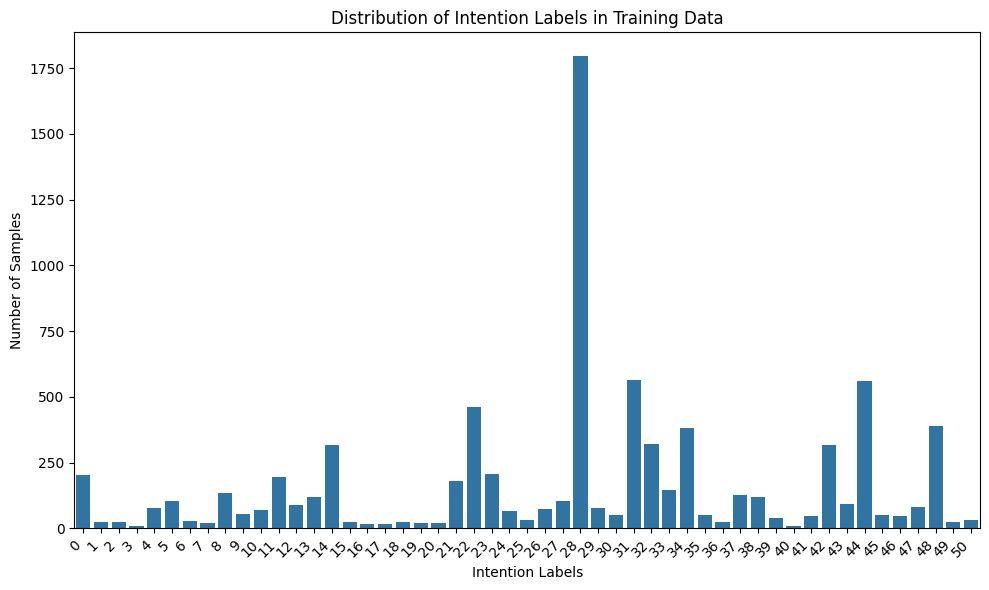

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate label distribution
label_counts = df_train['intention'].value_counts()

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xlabel("Intention Labels")
plt.ylabel("Number of Samples")
plt.title("Distribution of Intention Labels in Training Data")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


## Création du modèle baseline

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_tfidf = vectorizer.fit_transform(df_train['question_cleaned'])


In [14]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_train['intention'])


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
target_names = [str(c) for c in label_encoder.classes_]
print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.94      0.37      0.53        41
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         1
           4       1.00      0.54      0.70        13
           5       0.83      0.23      0.36        22
           6       1.00      0.25      0.40         4
           7       0.00      0.00      0.00         2
           8       0.85      0.41      0.55        27
           9       1.00      0.11      0.20         9
          10       1.00      0.25      0.40        16
          11       0.53      0.29      0.37        35
          12       1.00      0.25      0.40         8
          13       0.67      0.35      0.46        17
          14       0.44      0.59      0.50        56
          15       0.33      0.20      0.25         5
          16       0.00      0.00      0.00         4
          17       0.00    

/Users/dimitriguift/Documents/PROJET_DEEP_LEARNING/.nlp_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dimitriguift/Documents/PROJET_DEEP_LEARNING/.nlp_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dimitriguift/Documents/PROJET_DEEP_LEARNING/.nlp_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

### Soumission

In [17]:
X_test_tfidf = vectorizer.transform(df_test["question_cleaned"])

In [18]:
y_test_pred = model.predict(X_test_tfidf)
y_test_pred_labels = label_encoder.inverse_transform(y_test_pred)

In [19]:
submission_df = pd.DataFrame({
    "ID": df_test["ID"],
    "intention": y_test_pred_labels
})

submission_df.to_csv("Y_test.csv", index=False)

#### Modèle baseline avec rééquilibrage des classes

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced', 
    random_state=42
)

In [21]:
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [22]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = model.predict(X_val)

# Nom des classes en string pour éviter le bug de type
target_names = [str(cls) for cls in label_encoder.classes_]

print(classification_report(y_val, y_pred, target_names=target_names))
print(f"Accuracy : {accuracy_score(y_val, y_pred):.4f}")


              precision    recall  f1-score   support

           0       0.62      0.44      0.51        41
           1       0.04      0.20      0.07         5
           2       0.57      0.67      0.62         6
           3       0.50      1.00      0.67         1
           4       0.28      0.77      0.41        13
           5       0.33      0.59      0.43        22
           6       1.00      0.75      0.86         4
           7       0.00      0.00      0.00         2
           8       0.70      0.59      0.64        27
           9       0.15      0.33      0.21         9
          10       0.42      0.62      0.50        16
          11       0.23      0.40      0.29        35
          12       0.13      0.62      0.21         8
          13       0.50      0.82      0.62        17
          14       0.47      0.39      0.43        56
          15       0.33      1.00      0.50         5
          16       0.67      0.50      0.57         4
          17       0.14    

In [23]:
X_test_tfidf = vectorizer.transform(df_test["question_cleaned"])
y_test_pred = model.predict(X_test_tfidf)
y_test_labels = label_encoder.inverse_transform(y_test_pred)

df_submission = pd.DataFrame({
    "ID": df_test["ID"],
    "intention": y_test_labels
})
df_submission.to_csv("Y_test.csv", index=False)


## TF-IDF + XgBoost

In [24]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Si ce n’est pas déjà fait :
# X_tfidf = vectorizer.fit_transform(df_train['question_cleaned'])

# Encodage des labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_train['intention'])

# Split train / validation
X_train, X_val, y_train, y_val = train_test_split(X_tfidf, y_encoded, test_size=0.2, random_state=42)

# Création du classifieur XGBoost
model_xgb = xgb.XGBClassifier(
    objective='multi:softmax',  # Prédire la classe directement
    num_class=50,               # Nombre d’intentions
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

# Entraînement
model_xgb.fit(X_train, y_train)


/Users/dimitriguift/Documents/PROJET_DEEP_LEARNING/.nlp_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:50:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1, num_class=50, ...)

In [25]:
y_val_pred = model_xgb.predict(X_val)

print("Accuracy :", accuracy_score(y_val, y_val_pred))
target_names = [str(c) for c in label_encoder.classes_]
print(classification_report(y_val, y_val_pred, target_names=target_names))


Accuracy : 0.613947696139477
              precision    recall  f1-score   support

           0       0.69      0.44      0.54        41
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         6
           3       1.00      1.00      1.00         1
           4       0.50      0.54      0.52        13
           5       0.50      0.36      0.42        22
           6       1.00      0.75      0.86         4
           7       0.00      0.00      0.00         2
           8       0.86      0.70      0.78        27
           9       0.40      0.22      0.29         9
          10       0.80      0.50      0.62        16
          11       0.55      0.31      0.40        35
          12       0.27      0.50      0.35         8
          13       0.64      0.41      0.50        17
          14       0.38      0.46      0.42        56
          15       0.29      0.40      0.33         5
          16       0.00      0.00      0.00         

/Users/dimitriguift/Documents/PROJET_DEEP_LEARNING/.nlp_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dimitriguift/Documents/PROJET_DEEP_LEARNING/.nlp_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dimitriguift/Documents/PROJET_DEEP_LEARNING/.nlp_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

In [26]:
X_test_tfidf = vectorizer.transform(df_test["question_cleaned"])
y_test_pred = model_xgb.predict(X_test_tfidf)
y_test_labels = label_encoder.inverse_transform(y_test_pred)

df_submission = pd.DataFrame({
    "ID": df_test["ID"],
    "intention": y_test_labels
})
df_submission.to_csv("Y_test_1.csv", index=False)


## Modèle pré-entrainé (CAMEMBERT)

In [ ]:
# camembert_train.py

import torch
from torch.utils.data import Dataset, DataLoader
from transformers import CamembertTokenizer, CamembertForSequenceClassification
from sklearn.metrics import classification_report
import pandas as pd
import joblib

# ===============================
# 1. Prétraitement déjà effectué
# ===============================
# On suppose que df_train et df_test sont déjà en mémoire avec :
# - df_train['question_cleaned']
# - df_train['intention'] (labels textuels)
# - df_test['question_cleaned']
# Et qu'un label_encoder a déjà été entraîné sur df_train['intention']

# Encoder les labels
labels = label_encoder.transform(df_train['intention'])

# ===============================
# 2. Tokenisation CamemBERT
# ===============================
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")

class PososDataset(Dataset):
    def __init__(self, texts, labels=None):
        self.encodings = tokenizer(
            texts.tolist(), truncation=True, padding=True, max_length=128
        )
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

# Split train/val
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    df_train['question_cleaned'], labels, test_size=0.2, random_state=42
)

train_dataset = PososDataset(X_train, y_train)
val_dataset = PososDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# ===============================
# 3. Modèle Camembert
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CamembertForSequenceClassification.from_pretrained(
    "camembert-base", num_labels=len(label_encoder.classes_)
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# ===============================
# 4. Entraînement avec évaluation
# ===============================
for epoch in range(5):
    print(f"\nEpoch {epoch+1}")
    model.train()
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        outputs = model(**batch)
        outputs.loss.backward()
        optimizer.step()

    # Évaluation après chaque epoch
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            preds = torch.argmax(outputs.logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    target_names = [str(cls) for cls in label_encoder.classes_]
    print(classification_report(all_labels, all_preds, target_names=target_names))

# ===============================
# 5. Prédiction sur df_test
# ===============================
test_dataset = PososDataset(df_test['question_cleaned'])
test_loader = DataLoader(test_dataset, batch_size=16)

model.eval()
test_preds = []
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=-1)
        test_preds.extend(preds.cpu().numpy())

# Export
df_submission = pd.DataFrame({"ID": df_test["ID"], "intention": test_preds})
df_submission.to_csv("Y_test_2.csv", index=False)
print("Fichier Y_test_2.csv généré")


Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1


/Users/dimitriguift/Documents/PROJET_DEEP_LEARNING/.nlp_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dimitriguift/Documents/PROJET_DEEP_LEARNING/.nlp_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dimitriguift/Documents/PROJET_DEEP_LEARNING/.nlp_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

              precision    recall  f1-score   support

           0       0.44      0.10      0.16        41
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        13
           5       1.00      0.18      0.31        22
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         2
           8       1.00      0.26      0.41        27
           9       0.00      0.00      0.00         9
          10       0.00      0.00      0.00        16
          11       0.00      0.00      0.00        35
          12       0.00      0.00      0.00         8
          13       0.00      0.00      0.00        17
          14       0.26      0.36      0.30        56
          15       0.00      0.00      0.00         5
          16       0.00      0.00      0.00         4
          17       0.00    

/Users/dimitriguift/Documents/PROJET_DEEP_LEARNING/.nlp_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dimitriguift/Documents/PROJET_DEEP_LEARNING/.nlp_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dimitriguift/Documents/PROJET_DEEP_LEARNING/.nlp_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

              precision    recall  f1-score   support

           0       0.42      0.27      0.33        41
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        13
           5       0.75      0.55      0.63        22
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         2
           8       0.49      0.67      0.56        27
           9       0.00      0.00      0.00         9
          10       0.00      0.00      0.00        16
          11       0.63      0.49      0.55        35
          12       0.00      0.00      0.00         8
          13       0.00      0.00      0.00        17
          14       0.31      0.77      0.44        56
          15       0.00      0.00      0.00         5
          16       0.00      0.00      0.00         4
          17       0.00    

/Users/dimitriguift/Documents/PROJET_DEEP_LEARNING/.nlp_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dimitriguift/Documents/PROJET_DEEP_LEARNING/.nlp_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dimitriguift/Documents/PROJET_DEEP_LEARNING/.nlp_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

              precision    recall  f1-score   support

           0       0.57      0.76      0.65        41
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        13
           5       0.49      0.86      0.62        22
           6       0.00      0.00      0.00         4
           7       0.25      0.50      0.33         2
           8       0.38      0.78      0.51        27
           9       0.00      0.00      0.00         9
          10       0.00      0.00      0.00        16
          11       0.63      0.63      0.63        35
          12       0.00      0.00      0.00         8
          13       1.00      0.12      0.21        17
          14       0.34      0.79      0.47        56
          15       0.00      0.00      0.00         5
          16       0.00      0.00      0.00         4
          17       0.00    

/Users/dimitriguift/Documents/PROJET_DEEP_LEARNING/.nlp_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dimitriguift/Documents/PROJET_DEEP_LEARNING/.nlp_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dimitriguift/Documents/PROJET_DEEP_LEARNING/.nlp_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

              precision    recall  f1-score   support

           0       0.64      0.73      0.68        41
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        13
           5       0.45      0.77      0.57        22
           6       0.00      0.00      0.00         4
           7       0.25      1.00      0.40         2
           8       0.66      0.93      0.77        27
           9       0.00      0.00      0.00         9
          10       0.00      0.00      0.00        16
          11       0.58      0.74      0.65        35
          12       0.00      0.00      0.00         8
          13       0.53      0.47      0.50        17
          14       0.45      0.84      0.58        56
          15       0.00      0.00      0.00         5
          16       0.00      0.00      0.00         4
          17       0.00    

/Users/dimitriguift/Documents/PROJET_DEEP_LEARNING/.nlp_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dimitriguift/Documents/PROJET_DEEP_LEARNING/.nlp_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dimitriguift/Documents/PROJET_DEEP_LEARNING/.nlp_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

              precision    recall  f1-score   support

           0       0.61      0.76      0.67        41
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         6
           3       0.00      0.00      0.00         1
           4       0.50      0.08      0.13        13
           5       0.49      0.86      0.62        22
           6       0.00      0.00      0.00         4
           7       0.25      1.00      0.40         2
           8       0.65      0.89      0.75        27
           9       0.00      0.00      0.00         9
          10       1.00      0.06      0.12        16
          11       0.62      0.74      0.68        35
          12       0.00      0.00      0.00         8
          13       0.52      0.71      0.60        17
          14       0.48      0.79      0.59        56
          15       0.00      0.00      0.00         5
          16       0.00      0.00      0.00         4
          17       0.00    

## Modèle pré-entrainé (CAMEMBERT amélioré)